In [59]:
import numpy as np
import pandas as pd
import pandas.api.types
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold

import wandb
import lightgbm as lgb

df_train = pd.read_csv("../data/train-metadata.csv")
df_test = pd.read_csv("../data/test-metadata.csv")

/tmp/ipykernel_1049773/2186680580.py:14: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("../data/train-metadata.csv")


### Features

In [3]:
def feature_engineering(df):
    # New features to try...
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]

    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df_train["tbp_lv_y"], df_train["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    # Taken from: https://www.kaggle.com/code/dschettler8845/isic-detect-skin-cancer-let-s-learn-together
    df["color_variance_ratio"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_stdLExt"]
    df["border_color_interaction"] = df["tbp_lv_norm_border"] * df["tbp_lv_norm_color"]
    df["size_color_contrast_ratio"] = df["clin_size_long_diam_mm"] / df["tbp_lv_deltaLBnorm"]
    df["age_normalized_nevi_confidence"] = df["tbp_lv_nevi_confidence"] / df["age_approx"]
    df["color_asymmetry_index"] = df["tbp_lv_radial_color_std_max"] * df["tbp_lv_symm_2axis"]
    df["3d_volume_approximation"] = df["tbp_lv_areaMM2"] * np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
    df["color_range"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs() + (df["tbp_lv_A"] - df["tbp_lv_Aext"]).abs() + (df["tbp_lv_B"] - df["tbp_lv_Bext"]).abs()
    df["shape_color_consistency"] = df["tbp_lv_eccentricity"] * df["tbp_lv_color_std_mean"]
    df["border_length_ratio"] = df["tbp_lv_perimeterMM"] / (2 * np.pi * np.sqrt(df["tbp_lv_areaMM2"] / np.pi))
    df["age_size_symmetry_index"] = df["age_approx"] * df["clin_size_long_diam_mm"] * df["tbp_lv_symm_2axis"]
    # Until here.

    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index", 
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
        
        "color_variance_ratio", "border_color_interaction", "size_color_contrast_ratio",
        "age_normalized_nevi_confidence", "color_asymmetry_index", "3d_volume_approximation",
        "color_range", "shape_color_consistency", "border_length_ratio", "age_size_symmetry_index",
    ]
    new_cat_cols = ["combined_anatomical_site"]
    return df, new_num_cols, new_cat_cols

num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
]
df_train[num_cols] = df_train[num_cols].fillna(df_train[num_cols].median())
df_train, new_num_cols, new_cat_cols = feature_engineering(df_train.copy())
df_test, _, _ = feature_engineering(df_test.copy())
num_cols += new_num_cols
# anatom_site_general
cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols
train_cols = num_cols + cat_cols

### Load preprocessed data

In [4]:
df_train = pd.read_csv("../data/stratified_5_fold_train_metadata.csv")

/tmp/ipykernel_1049773/1216159966.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("../data/stratified_5_fold_train_metadata.csv")


### Train and eval

In [5]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc


lgb_params =  {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "n_estimators": 531, # 200,
    'learning_rate': 0.020961882958412847, # 0.05,    
    'lambda_l1': 0.031850406238810657, #0.0004681884533249742, 
    'lambda_l2': 9.352820586794987, # 8.765240856362274, 
    'num_leaves': 60, # 136, 
    'feature_fraction': 0.5270436775267011, # 0.5392005444882538, 
    'bagging_fraction': 0.9745808187865352, # 0.9577412548866563, 
    'bagging_freq': 9, # 6,
    'min_child_samples': 65, # 60,
    "device": "gpu"
}

scores = []
models = []
targets = []
preds_fold = []
for fold in range(5):
    _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
    _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
    model = lgb.LGBMRegressor(
        **lgb_params
    )
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict(_df_valid[train_cols])
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    
    targets.extend(_df_valid["target"])
    preds_fold.extend(preds)

    scores.append(score)
    models.append(model)

score = np.mean(scores)
print(f"LGBM Score: {score:.5f}")

fold: 0 - Partial AUC Score: 0.17229
fold: 1 - Partial AUC Score: 0.15146
fold: 2 - Partial AUC Score: 0.17262
fold: 3 - Partial AUC Score: 0.15597
fold: 4 - Partial AUC Score: 0.15790
LGBM Score: 0.16205


In [7]:
assert len(targets) == len(preds_fold)

In [8]:
df_train.head(1)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,border_color_interaction,size_color_contrast_ratio,age_normalized_nevi_confidence,color_asymmetry_index,3d_volume_approximation,color_range,shape_color_consistency,border_length_ratio,age_size_symmetry_index,fold
0,ISIC_0015670,0,IP_1235828,60.0,1,lower extremity,3.04,TBP tile: close-up,1,20.244422,...,0.0,0.52556,0.000044,0.0,2022.449088,14.608375,0.0,1.478676,107.702857,4


In [33]:
analysis_df = df_train[["isic_id", "target", "patient_id", "fold"]]

i = 0
_dfs = []

for fold in range(5):
    _df = analysis_df[analysis_df["fold"] == fold].reset_index(drop=True)
    length = len(_df)
    _targets, _preds = targets[i:i+length], preds_fold[i:i+length]
    i += length
    _df["_target"] = _targets
    _df["_preds"] = _preds
    _dfs.append(_df)

analysis_df = pd.concat(_dfs)

In [34]:
analysis_df

,isic_id,target,patient_id,fold,_target,_preds
0,ISIC_0051648,0,IP_0218255,0,0,0.000021
1,ISIC_0051822,0,IP_4934005,0,0,0.000123
2,ISIC_0051983,0,IP_5579051,0,0,0.000050
3,ISIC_0052004,0,IP_2608033,0,0,0.000010
4,ISIC_0052122,0,IP_1117889,0,0,0.000318
...,...,...,...,...,...,...
80205,ISIC_9999261,0,IP_3026867,4,0,0.000505
80206,ISIC_9999292,0,IP_7322743,4,0,0.000033
80207,ISIC_9999361,0,IP_8457418,4,0,0.000010
80208,ISIC_9999696,0,IP_9553357,4,0,0.000645


In [36]:
assert (analysis_df.target.values == analysis_df._target.values).sum() == 401059

In [37]:
fpr, tpr, thresholds = roc_curve(analysis_df._target.values, analysis_df._preds.values)
roc_auc = auc(fpr, tpr)

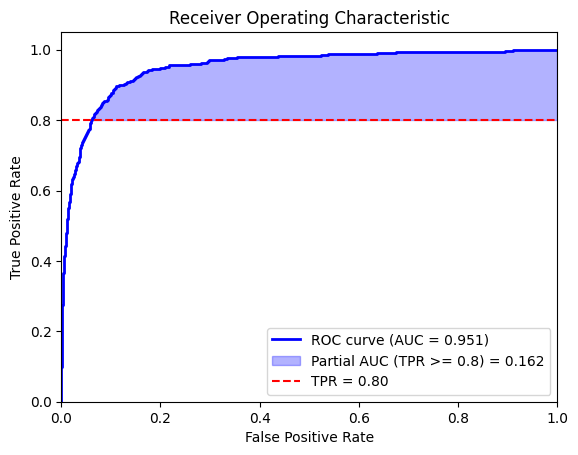

In [40]:
tpr_threshold = 0.8

plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (AUC = %0.3f)" % roc_auc)
start_idx = np.where(tpr >= tpr_threshold)[0][0]
fpr_shade = np.concatenate(([fpr[start_idx]], fpr[start_idx:], [1]))
tpr_shade = np.concatenate(([tpr_threshold], tpr[start_idx:], [tpr_threshold]))
plt.fill_between(
    fpr_shade,
    tpr_shade,
    y2=0.8,
    alpha=0.3,
    color="blue",
    label="Partial AUC (TPR >= 0.8) = %0.3f" % score,
)
plt.axhline(y=tpr_threshold, color="red", linestyle="--", label="TPR = 0.80")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

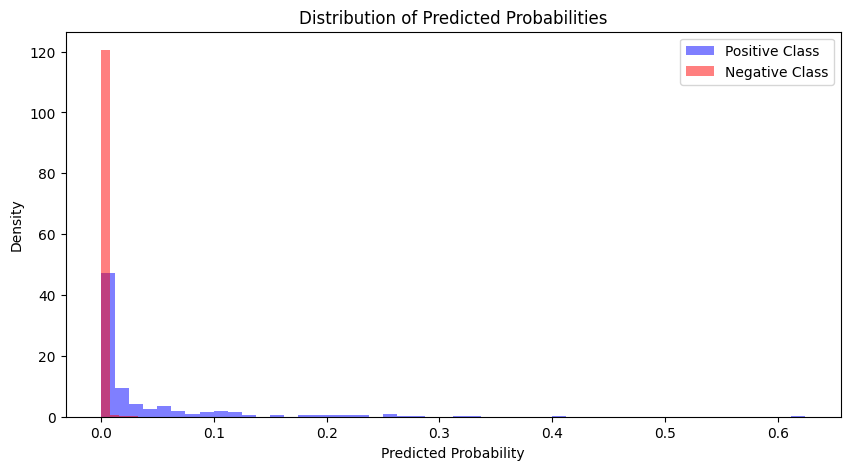

In [54]:
positive_preds = analysis_df[analysis_df['target'] == 1]['_preds']
negative_preds = analysis_df[analysis_df['target'] == 0]['_preds']

plt.figure(figsize=(10, 5))
plt.hist(positive_preds, bins=50, alpha=0.5, label='Positive Class', color='blue', density=True)
plt.hist(negative_preds, bins=50, alpha=0.5, label='Negative Class', color='red', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.title('Distribution of Predicted Probabilities')
plt.show()

/tmp/ipykernel_1049773/501427667.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([positive_preds, negative_preds], labels=['Positive Class', 'Negative Class'], patch_artist=True,


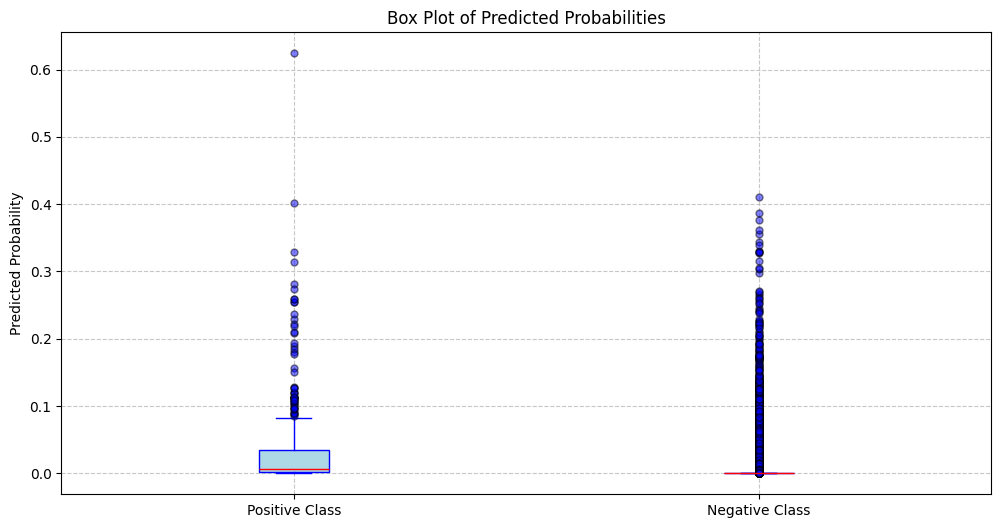

In [58]:
plt.figure(figsize=(12, 6))
plt.boxplot([positive_preds, negative_preds], labels=['Positive Class', 'Negative Class'], patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(markerfacecolor='blue', marker='o', markersize=5, linestyle='none', alpha=0.5))

plt.ylabel('Predicted Probability')
plt.title('Box Plot of Predicted Probabilities')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [57]:
positive_summary = positive_preds.describe()
negative_summary = negative_preds.describe()

print("Positive Class Summary Statistics:")
print(positive_summary.T)

print("\nNegative Class Summary Statistics:")
print(negative_summary.T)

Positive Class Summary Statistics:
count    393.000000
mean       0.034291
std        0.066578
min        0.000014
25%        0.001268
50%        0.006538
75%        0.034225
max        0.624290
Name: _preds, dtype: float64

Negative Class Summary Statistics:
count    400666.000000
mean          0.000518
std           0.004842
min           0.000003
25%           0.000026
50%           0.000057
75%           0.000158
max           0.411029
Name: _preds, dtype: float64


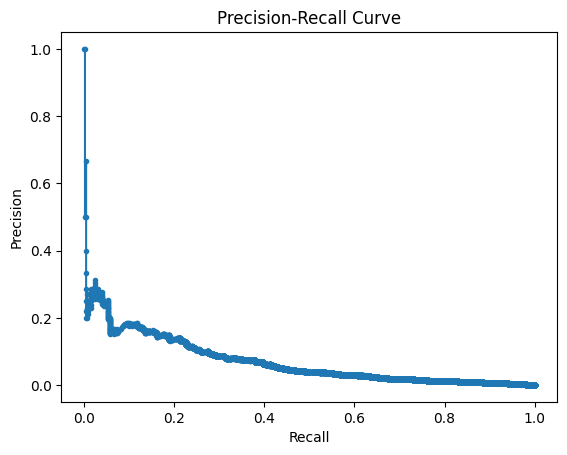

In [44]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(analysis_df._target.values, analysis_df._preds.values)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

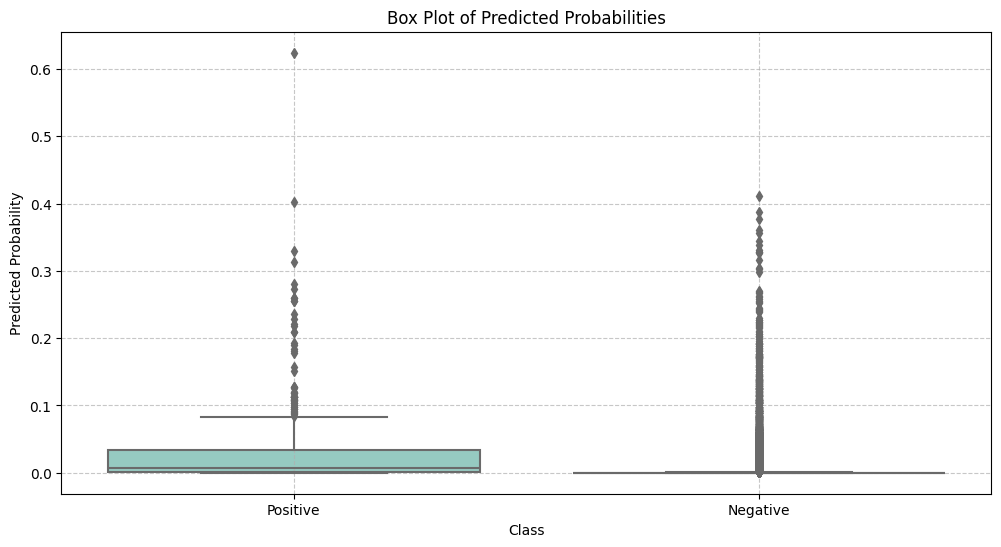

In [60]:
data = pd.DataFrame({
    'Predicted Probability': list(positive_preds) + list(negative_preds),
    'Class': ['Positive'] * len(positive_preds) + ['Negative'] * len(negative_preds)
})

# Box Plot with improved aesthetics
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='Predicted Probability', data=data, palette="Set3")
plt.title('Box Plot of Predicted Probabilities')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

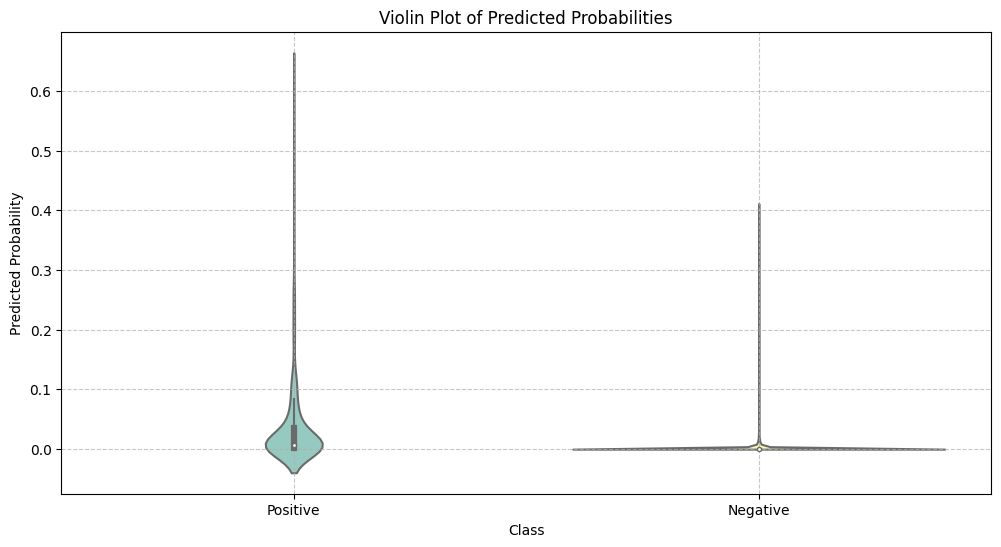

In [61]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Class', y='Predicted Probability', data=data, palette="Set3")
plt.title('Violin Plot of Predicted Probabilities')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_1049773/2506122232.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=positive_preds, shade=True, color='blue', label='Positive Class')
/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_1049773/2506122232.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=negative_preds, shade=True, color='red', label='Negative Class')
/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. C

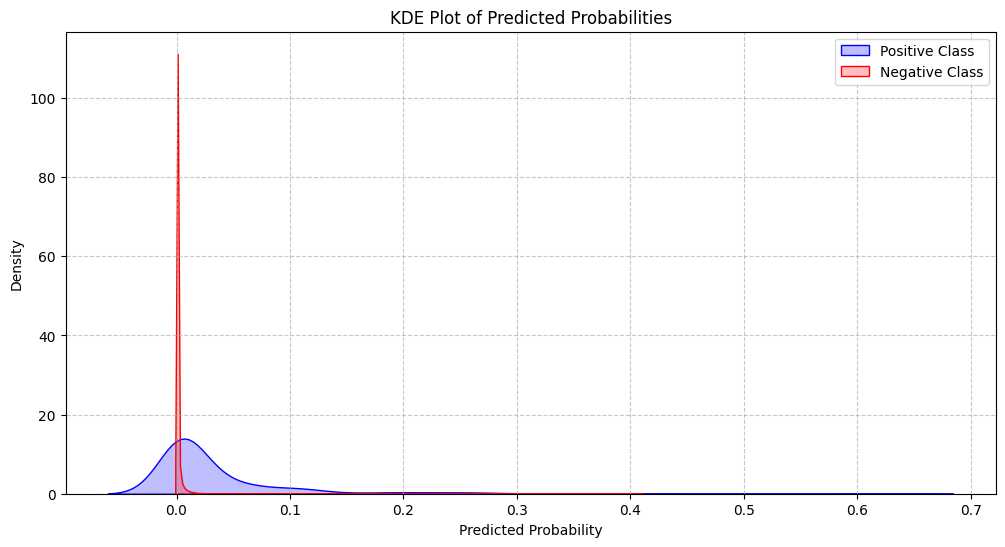

In [62]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=positive_preds, shade=True, color='blue', label='Positive Class')
sns.kdeplot(data=negative_preds, shade=True, color='red', label='Negative Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('KDE Plot of Predicted Probabilities')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

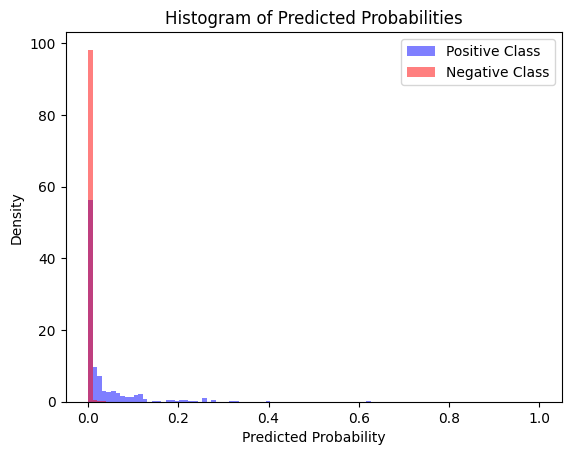

Overlap ranges of predicted probabilities: [0.13131313 0.16161616 0.24242424 0.26262626 0.28282828 0.29292929
 0.3030303  0.33333333 0.34343434 0.35353535 0.36363636 0.37373737
 0.38383838 0.4040404  0.41414141 0.42424242 0.43434343 0.44444444
 0.45454545 0.46464646 0.47474747 0.48484848 0.49494949 0.50505051
 0.51515152 0.52525253 0.53535354 0.54545455 0.55555556 0.56565657
 0.57575758 0.58585859 0.5959596  0.60606061 0.62626263 0.63636364
 0.64646465 0.65656566 0.66666667 0.67676768 0.68686869 0.6969697
 0.70707071 0.71717172 0.72727273 0.73737374 0.74747475 0.75757576
 0.76767677 0.77777778 0.78787879 0.7979798  0.80808081 0.81818182
 0.82828283 0.83838384 0.84848485 0.85858586 0.86868687 0.87878788
 0.88888889 0.8989899  0.90909091 0.91919192 0.92929293 0.93939394
 0.94949495 0.95959596 0.96969697 0.97979798 0.98989899]
Number of hard-to-classify samples: 144


,isic_id,target,patient_id,fold,_target,_preds
549,ISIC_0138049,0,IP_7330399,0,0,0.255396
938,ISIC_0182272,0,IP_2068150,0,0,0.136734
12636,ISIC_1638858,0,IP_1475510,0,0,0.180689
13650,ISIC_1772613,0,IP_5903482,0,0,0.192421
17969,ISIC_2325276,0,IP_4825600,0,0,0.206190


In [64]:
# Define the bins for histogram
bins = np.linspace(0, 1, 100)

# Plot the histograms to visually inspect the overlap
plt.hist(positive_preds, bins, alpha=0.5, label='Positive Class', color='blue', density=True)
plt.hist(negative_preds, bins, alpha=0.5, label='Negative Class', color='red', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.title('Histogram of Predicted Probabilities')
plt.show()

# Find the overlap range
# Define a threshold to consider significant overlap, e.g., 0.01 density difference
threshold = 0.01

positive_hist, bin_edges = np.histogram(positive_preds, bins=bins, density=True)
negative_hist, _ = np.histogram(negative_preds, bins=bins, density=True)

overlap_bins = (np.abs(positive_hist - negative_hist) < threshold)
overlap_ranges = bin_edges[np.where(overlap_bins)]

# Print the overlap ranges
print("Overlap ranges of predicted probabilities:", overlap_ranges)

# Extract the hard-to-classify samples
hard_samples = analysis_df[(analysis_df['_preds'] >= overlap_ranges.min()) & (analysis_df['_preds'] <= overlap_ranges.max())]

# Display the hard samples
print("Number of hard-to-classify samples:", len(hard_samples))
hard_samples.head()

In [67]:
hard_samples._target.value_counts()

_target
0    121
1     23
Name: count, dtype: int64

In [68]:
hard_samples.loc[hard_samples._target == 1]

,isic_id,target,patient_id,fold,_target,_preds
29667,ISIC_3780711,1,IP_8567950,0,1,0.402159
44912,ISIC_5643847,1,IP_2068150,0,1,0.281034
61213,ISIC_7647494,1,IP_3154471,0,1,0.180755
61449,ISIC_7676691,1,IP_9989989,0,1,0.189704
40346,ISIC_5068210,1,IP_2216403,1,1,0.184125
60768,ISIC_7606683,1,IP_5114481,1,1,0.273516
73173,ISIC_9127831,1,IP_5799983,1,1,0.156828
79971,ISIC_9972877,1,IP_8877928,1,1,0.229174
1776,ISIC_0293670,1,IP_2456971,2,1,0.208929
4892,ISIC_0664135,1,IP_2456971,2,1,0.151176
